In [ ]:
! pip install ultralytics opencv-python-headless supervision wget matplotlib PyYAML tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Example path if you saved the shortcut to "My Drive"
data_path = "/content/drive/My Drive/minneApple_dataset"

# Optional: list files
os.listdir(data_path)


['.DS_Store', 'minneapple.yaml', 'train', 'valid', 'test']

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
import os
from ultralytics.data.utils import download
import yaml
import random
from IPython.display import Image, display
import pandas as pd


def train_yolo_model(dataset_path, epochs, train_name="experiment"):
    """
    Train YOLOv10 model on a dataset
    """

    # TO-DO: Download and train YOLO8 model.
    model = YOLO("yolov10m.pt")  # Load a pre-trained YOLOv8 model
    results = model.train(data=str(dataset_path / 'minneapple.yaml'),
                          epochs=epochs,
                          imgsz=640,
                          name=train_name)
    return model, results


mAP (mean Average Precision).  
- mAP@0.50 (or mAP50): Evaluates how well predictions match the ground truth at a single IoU threshold of 0.50.
- IoU (Intersection over Union) = area of overlap / area of union.
- A detection is considered correct if IoU ≥ 0.50.
- Lenient — good for understanding if the model can generally find objects.

| Metric         | IoU Threshold      | Strictness | Use Case                     |
| -------------- | ------------------ | ---------- | ---------------------------- |
| mAP\@0.50      | IoU ≥ 0.50         | Low        | Quick check of detection     |
| mAP\@0.50:0.95 | IoU 0.50–0.95 avg. | High       | Real-world precision & rigor |


In [ ]:
def show_confusion_matrix(metrics):
    confusion_path = metrics.save_dir / "confusion_matrix.png"
    if confusion_path.exists():
        display(Image(filename=str(confusion_path)))
    else:
        print("No confusion matrix image found.")

In [ ]:
def evaluate_model(model, dataset_path):
    """
    Evaluate trained model on test-set using mAP50 and mAP50-95, precision and recall.
    """
    test_data = str(dataset_path / 'minneapple.yaml')
    metrics = model.val(data=test_data)

    # Extract from results_dict
    precision = metrics.results_dict['metrics/precision(B)']
    recall = metrics.results_dict['metrics/recall(B)']
    map50 = metrics.results_dict['metrics/mAP50(B)']
    map95 = metrics.results_dict['metrics/mAP50-95(B)']


    print("\n📊 Evaluation Metrics")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"mAP@0.50:       {map50:.4f}")
    print(f"mAP@0.5:0.95:   {map95:.4f}")

    if precision is not None and recall is not None:
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        print(f"F1 Score:       {f1:.4f}")

    if recall < 0.7:
        print("⚠️  Could improve recall — model is missing some objects (false negatives).")
    if precision < 0.7:
        print("⚠️  Could improve precision — model may have false positives.")

    return metrics



In [ ]:
def evaluate_model_on_counting():
    gt_file = "/content/drive/MyDrive/minneApple_dataset/test/ground_truth.txt"
    pred_dir = "/content/drive/MyDrive/yolo10_output/predict_test/labels"

    gt_df = pd.read_csv(gt_file)
    gt_df["image_id"] = gt_df["Image"].str.replace(".png", "", regex=False)

    # Count predicted boxes per image
    pred_counts = {}
    for fname in os.listdir(pred_dir):
        if fname.endswith(".txt"):
            with open(os.path.join(pred_dir, fname), "r") as f:
                count = len(f.readlines())
            pred_counts[fname.replace(".txt", "")] = count

    # Merge and compute metrics
    gt_df["predicted"] = gt_df["image_id"].map(pred_counts).fillna(0).astype(int)

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(gt_df["count"], gt_df["predicted"])
    mse = mean_squared_error(gt_df["count"], gt_df["predicted"])
    rmse = np.sqrt(mse)
    r2 = r2_score(gt_df["count"], gt_df["predicted"])

    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²   : {r2:.3f}")

In [ ]:


def visualize_predictions(model, dataset_path, num_images=3, conf_threshold=0.5):
    """
    Visualize predictions on n sample images
        Args:
        model: Trained YOLO model.
        dataset_path (str): Path to the dataset YAML file.
        num_images (int): Number of images to visualize.
        conf_threshold (float): Confidence threshold for predictions.
    """

    # TODO: Visualise bounding boxes and prediction on n images
    with open(dataset_path, 'r') as f:
        data = yaml.safe_load(f)
    yaml_dir = os.path.dirname(dataset_path)
    val_dir = os.path.join(yaml_dir, data['val'])


    # Collect image paths
    exts = ('.jpg', '.jpeg', '.png')
    image_files = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.lower().endswith(exts)]
    sample_images = random.sample(image_files, min(num_images, len(image_files)))

    # Create output folder
    output_dir = "predictions"
    os.makedirs(output_dir, exist_ok=True)

    for i, img_path in enumerate(sample_images):
        # Run prediction
        results = model.predict(source=img_path, conf=conf_threshold, save=False, verbose=False)

        # Get annotated image
        pred_img = results[0].plot()  # Numpy image with drawn predictions

        # Save to file
        out_path = os.path.join(output_dir, f"prediction_{i+1}.png")
        cv2.imwrite(out_path, cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR))

        # Display the result
        plt.figure(figsize=(8, 6))
        plt.imshow(pred_img)
        plt.title(f"Prediction {i+1}")
        plt.axis("off")
        plt.show()

    plt.close('all')


In [ ]:
import torch
torch.cuda.empty_cache()
import gc

/content

Dataset structure:
Images directory: /content/drive/MyDrive/minneApple_dataset/train/images
Number of images: 389

Starting training process...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/minneApple_dataset/minneapple.yaml, degrees=0.0, deterministic=True, device=-1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10m.pt, momentum=0.937, mosaic

train: Scanning /content/drive/MyDrive/minneApple_dataset/train/labels.cache... 389 images, 0 backgrounds, 0 corrupt: 100%|██████████| 389/389 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 3.8±3.6 ms, read: 132.6±103.4 MB/s, size: 1658.5 KB)


val: Scanning /content/drive/MyDrive/minneApple_dataset/valid/labels.cache... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<?, ?it/s]


Plotting labels to runs/detect/experiment8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/experiment8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.1G      4.581      4.502      2.146        359        640: 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        111       3627     0.0337      0.286     0.0216     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.24G      4.025      2.988      1.966        297        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        111       3627   0.000316    0.00276   0.000156   3.89e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.82G      4.223      3.144      1.984        354        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        111       3627     0.0554      0.301     0.0325     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.17G      4.307      2.934      1.992        268        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        111       3627     0.0058     0.0414    0.00302     0.0012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.76G      4.412       2.93       1.98        383        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        111       3627      0.275      0.507      0.217     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.71G       4.14      2.885      1.958        232        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        111       3627      0.285      0.518      0.232     0.0963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.98G      4.012      2.818      1.936        237        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        111       3627      0.278      0.536      0.224      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.61G      4.049      2.718      1.939        308        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        111       3627      0.524      0.561      0.503       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.46G      3.959      2.652      1.933        215        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        111       3627      0.509      0.533      0.479      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.49G      3.925      2.594      1.913        194        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        111       3627      0.524       0.57      0.519      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.37G      3.959      2.568      1.916        430        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        111       3627      0.516      0.578      0.526      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.44G      3.916      2.592      1.917        104        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        111       3627      0.505      0.582      0.527      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.29G      3.804      2.512      1.897        309        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        111       3627      0.541      0.583      0.537      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       9.3G      3.847      2.537      1.908        306        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        111       3627       0.49       0.56      0.503       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.3G      3.854      2.532      1.896        156        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        111       3627      0.551      0.588      0.554      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.02G      3.795      2.552      1.895        292        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        111       3627      0.467      0.507       0.47      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.97G      3.842      2.508      1.881        345        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        111       3627      0.539      0.599      0.536      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.4G      3.809      2.397      1.878        171        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        111       3627      0.534      0.594       0.55      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.76G       3.78      2.427      1.898        294        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        111       3627      0.525      0.584      0.542      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.25G      3.711      2.364      1.877        183        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        111       3627      0.556      0.591       0.56      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       9.6G      3.655       2.45      1.895        463        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        111       3627      0.552      0.587      0.558      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.87G      3.792      2.379       1.88        442        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        111       3627      0.581      0.595      0.598       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.55G       3.65      2.321      1.876        301        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        111       3627      0.552      0.621      0.578      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.17G      3.721      2.335      1.863        420        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        111       3627       0.55       0.62      0.567      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.78G      3.692      2.383      1.881        304        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        111       3627      0.567      0.614      0.597      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.12G      3.587      2.289      1.856        327        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        111       3627      0.574      0.627      0.598      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.57G      3.627      2.261      1.867        380        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        111       3627      0.592      0.631      0.604      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.8G      3.635      2.303      1.866        285        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        111       3627      0.573      0.582       0.57       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.49G      3.683      2.334      1.858        164        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        111       3627       0.59      0.629      0.619      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       9.7G      3.679      2.327      1.864        334        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        111       3627       0.58      0.619      0.607      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.26G      3.655      2.329       1.86        278        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        111       3627      0.578      0.608      0.603      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.07G      3.655      2.271      1.858        368        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        111       3627       0.59      0.622      0.589       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.61G      3.662      2.334      1.866        197        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        111       3627      0.546        0.6       0.56      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.34G      3.695      2.304      1.847        352        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        111       3627      0.617      0.616      0.625      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.32G      3.567      2.279      1.867        175        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        111       3627      0.555      0.598      0.594      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      10.2G      3.626      2.254      1.868        108        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        111       3627      0.598      0.648      0.621      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.23G      3.663       2.25       1.87        448        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        111       3627      0.615      0.637      0.645      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.6G        3.6      2.222      1.851        341        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        111       3627      0.596      0.633      0.626      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.98G      3.643      2.169      1.852        318        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        111       3627      0.625      0.637      0.641       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       9.7G      3.595      2.219      1.866        225        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        111       3627      0.606      0.631      0.613      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.88G      3.567       2.21      1.846        307        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        111       3627      0.622      0.635       0.64       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.42G      3.523      2.157      1.841        249        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        111       3627      0.576      0.617      0.603      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.44G       3.44      2.121      1.844        159        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        111       3627      0.595      0.653      0.622      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.66G      3.529      2.148      1.833        294        640: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        111       3627      0.555      0.601      0.597      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.93G      3.507      2.137      1.837        235        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        111       3627      0.589      0.629      0.614      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.5G       3.54      2.205       1.85        170        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        111       3627      0.574      0.615      0.603      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.75G      3.487      2.112      1.841        289        640: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        111       3627      0.597      0.649      0.622      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.06G      3.531      2.143      1.841        292        640: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        111       3627      0.597      0.648      0.625      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.38G      3.497       2.18      1.839        352        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        111       3627        0.6      0.629       0.61      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      10.1G      3.516      2.136       1.84        270        640: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        111       3627      0.596      0.622      0.615      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.3G      3.482      2.096      1.827        413        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        111       3627      0.616      0.644      0.631      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       9.9G      3.564      2.207      1.842        204        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        111       3627      0.614      0.653      0.639      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.19G      3.525      2.139       1.84        271        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        111       3627      0.607      0.645      0.635      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.1G      3.433      2.057      1.833        281        640: 100%|██████████| 25/25 [00:19<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        111       3627      0.585      0.625      0.624      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.26G      3.481      2.115      1.836        139        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        111       3627       0.61      0.646      0.637      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.35G       3.37      2.019      1.823        382        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        111       3627        0.6       0.66       0.64      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.85G      3.479       2.11      1.832        137        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        111       3627      0.621      0.629      0.628      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.76G      3.409      2.044      1.823        314        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        111       3627      0.607      0.636      0.634      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.32G      3.397      2.057      1.816        163        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        111       3627      0.634      0.667      0.658      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.18G      3.426      2.049      1.814        331        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        111       3627      0.606      0.649      0.634      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.3G      3.394      2.066      1.818        252        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        111       3627      0.621       0.67       0.66       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.94G      3.411      1.972      1.811        469        640: 100%|██████████| 25/25 [00:19<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        111       3627      0.623      0.657      0.641      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.52G       3.37      1.968      1.807        427        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        111       3627      0.602      0.665      0.609      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       9.1G      3.348      1.981      1.823        360        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        111       3627      0.632      0.658      0.658      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.54G      3.351      1.953      1.813        224        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        111       3627      0.617      0.647       0.64      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.8G      3.383      1.938      1.808        195        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        111       3627       0.63       0.68      0.666      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       9.2G      3.353      1.957      1.814        244        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        111       3627      0.628      0.663      0.665      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.11G       3.33      1.962      1.821        129        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        111       3627      0.617       0.66      0.642      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.89G      3.392      1.969      1.811        274        640: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        111       3627      0.638      0.658      0.652      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.1G      3.389      1.983      1.814        200        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        111       3627      0.586      0.638       0.62      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100        11G      3.323      1.971       1.81        222        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        111       3627      0.623      0.673      0.651      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.69G       3.37      1.928      1.808        423        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        111       3627      0.651      0.659      0.665      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.89G      3.354      1.975        1.8        250        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        111       3627       0.62       0.66      0.643      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.35G       3.31      1.904      1.798        344        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        111       3627      0.633      0.669      0.659      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.35G      3.351      1.933      1.802        153        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        111       3627      0.644       0.68      0.667      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.63G      3.317        1.9      1.797        251        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        111       3627      0.641       0.68      0.666      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       9.7G      3.324      1.896      1.812        336        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        111       3627      0.623      0.687      0.664      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.96G      3.262      1.853      1.802        316        640: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        111       3627      0.648      0.679      0.678      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.27G      3.337      1.907      1.809        137        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        111       3627      0.633      0.663      0.656      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100        10G      3.299      1.882       1.79        298        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        111       3627      0.642      0.666      0.668      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.49G      3.248      1.826      1.797        323        640: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        111       3627      0.624      0.663      0.653      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.74G      3.203      1.835      1.794        169        640: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        111       3627      0.635      0.669      0.659      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.08G      3.251      1.851      1.789        330        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        111       3627      0.626      0.663      0.655      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.53G      3.253      1.823      1.803        266        640: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        111       3627      0.628       0.68      0.667      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.48G      3.225      1.833       1.78        262        640: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        111       3627      0.649      0.685      0.662      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.33G      3.216       1.77       1.79        351        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        111       3627      0.647      0.678      0.659      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.66G      3.174      1.791      1.802        260        640: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        111       3627      0.651      0.664      0.655      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.62G      3.219      1.802      1.787        330        640: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        111       3627      0.634      0.686      0.668      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.53G      3.194      1.814      1.801        300        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        111       3627      0.638      0.665      0.657       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      10.1G      3.212      1.767      1.775        308        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        111       3627      0.642      0.675      0.669      0.334


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.58G      3.178       1.78      1.812        152        640: 100%|██████████| 25/25 [00:22<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        111       3627      0.641      0.676      0.658       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       8.4G      3.121      1.763      1.807        211        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        111       3627       0.64      0.675      0.666      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       8.5G      3.143      1.785       1.81         89        640: 100%|██████████| 25/25 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        111       3627      0.626      0.673      0.654      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.6G      3.111      1.735      1.791        138        640: 100%|██████████| 25/25 [00:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        111       3627      0.649      0.653      0.667      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.46G      3.102      1.702      1.792        137        640: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        111       3627      0.638      0.677       0.66      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.41G      3.122      1.716      1.805        138        640: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        111       3627      0.643      0.675      0.672      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       8.4G      3.061      1.664      1.796        196        640: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        111       3627      0.644      0.684      0.677       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.56G      3.055      1.676      1.788        127        640: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        111       3627      0.644      0.679      0.669      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.45G      3.055      1.662      1.796        132        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        111       3627      0.645       0.68      0.669      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.43G      3.004      1.606      1.786         91        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        111       3627       0.64      0.683      0.667      0.337



100 epochs completed in 0.652 hours.
Optimizer stripped from runs/detect/experiment8/weights/last.pt, 33.5MB
Optimizer stripped from runs/detect/experiment8/weights/best.pt, 33.5MB

Validating runs/detect/experiment8/weights/best.pt...
Searching for 1 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,313,747 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


                   all        111       3627      0.647       0.68      0.678      0.343
Speed: 0.4ms preprocess, 8.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/experiment8
Searching for 1 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]

image 1/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image1.png: 640x384 109 apples, 23.6ms
image 2/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image116.png: 640x384 120 apples, 34.2ms
image 3/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image121.png: 640x384 129 apples, 24.5ms
image 4/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image176.png: 640x384 128 apples, 24.8ms
image 5/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image181.png: 640x384 137 apples, 22.4ms
image 6/56 /content/drive/MyDrive/minneApple_dataset/test/images

val: Scanning /content/drive/MyDrive/minneApple_dataset/valid/labels.cache... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


                   all        111       3627      0.648       0.68      0.679      0.342
Speed: 4.1ms preprocess, 15.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/experiment82

📊 Evaluation Metrics
Precision:      0.6478
Recall:         0.6796
mAP@0.50:       0.6786
mAP@0.5:0.95:   0.3424
F1 Score:       0.6633
⚠️  Could improve recall — model is missing some objects (false negatives).
⚠️  Could improve precision — model may have false positives.
MAE : 743.23
RMSE: 749.82
R²   : -885.255


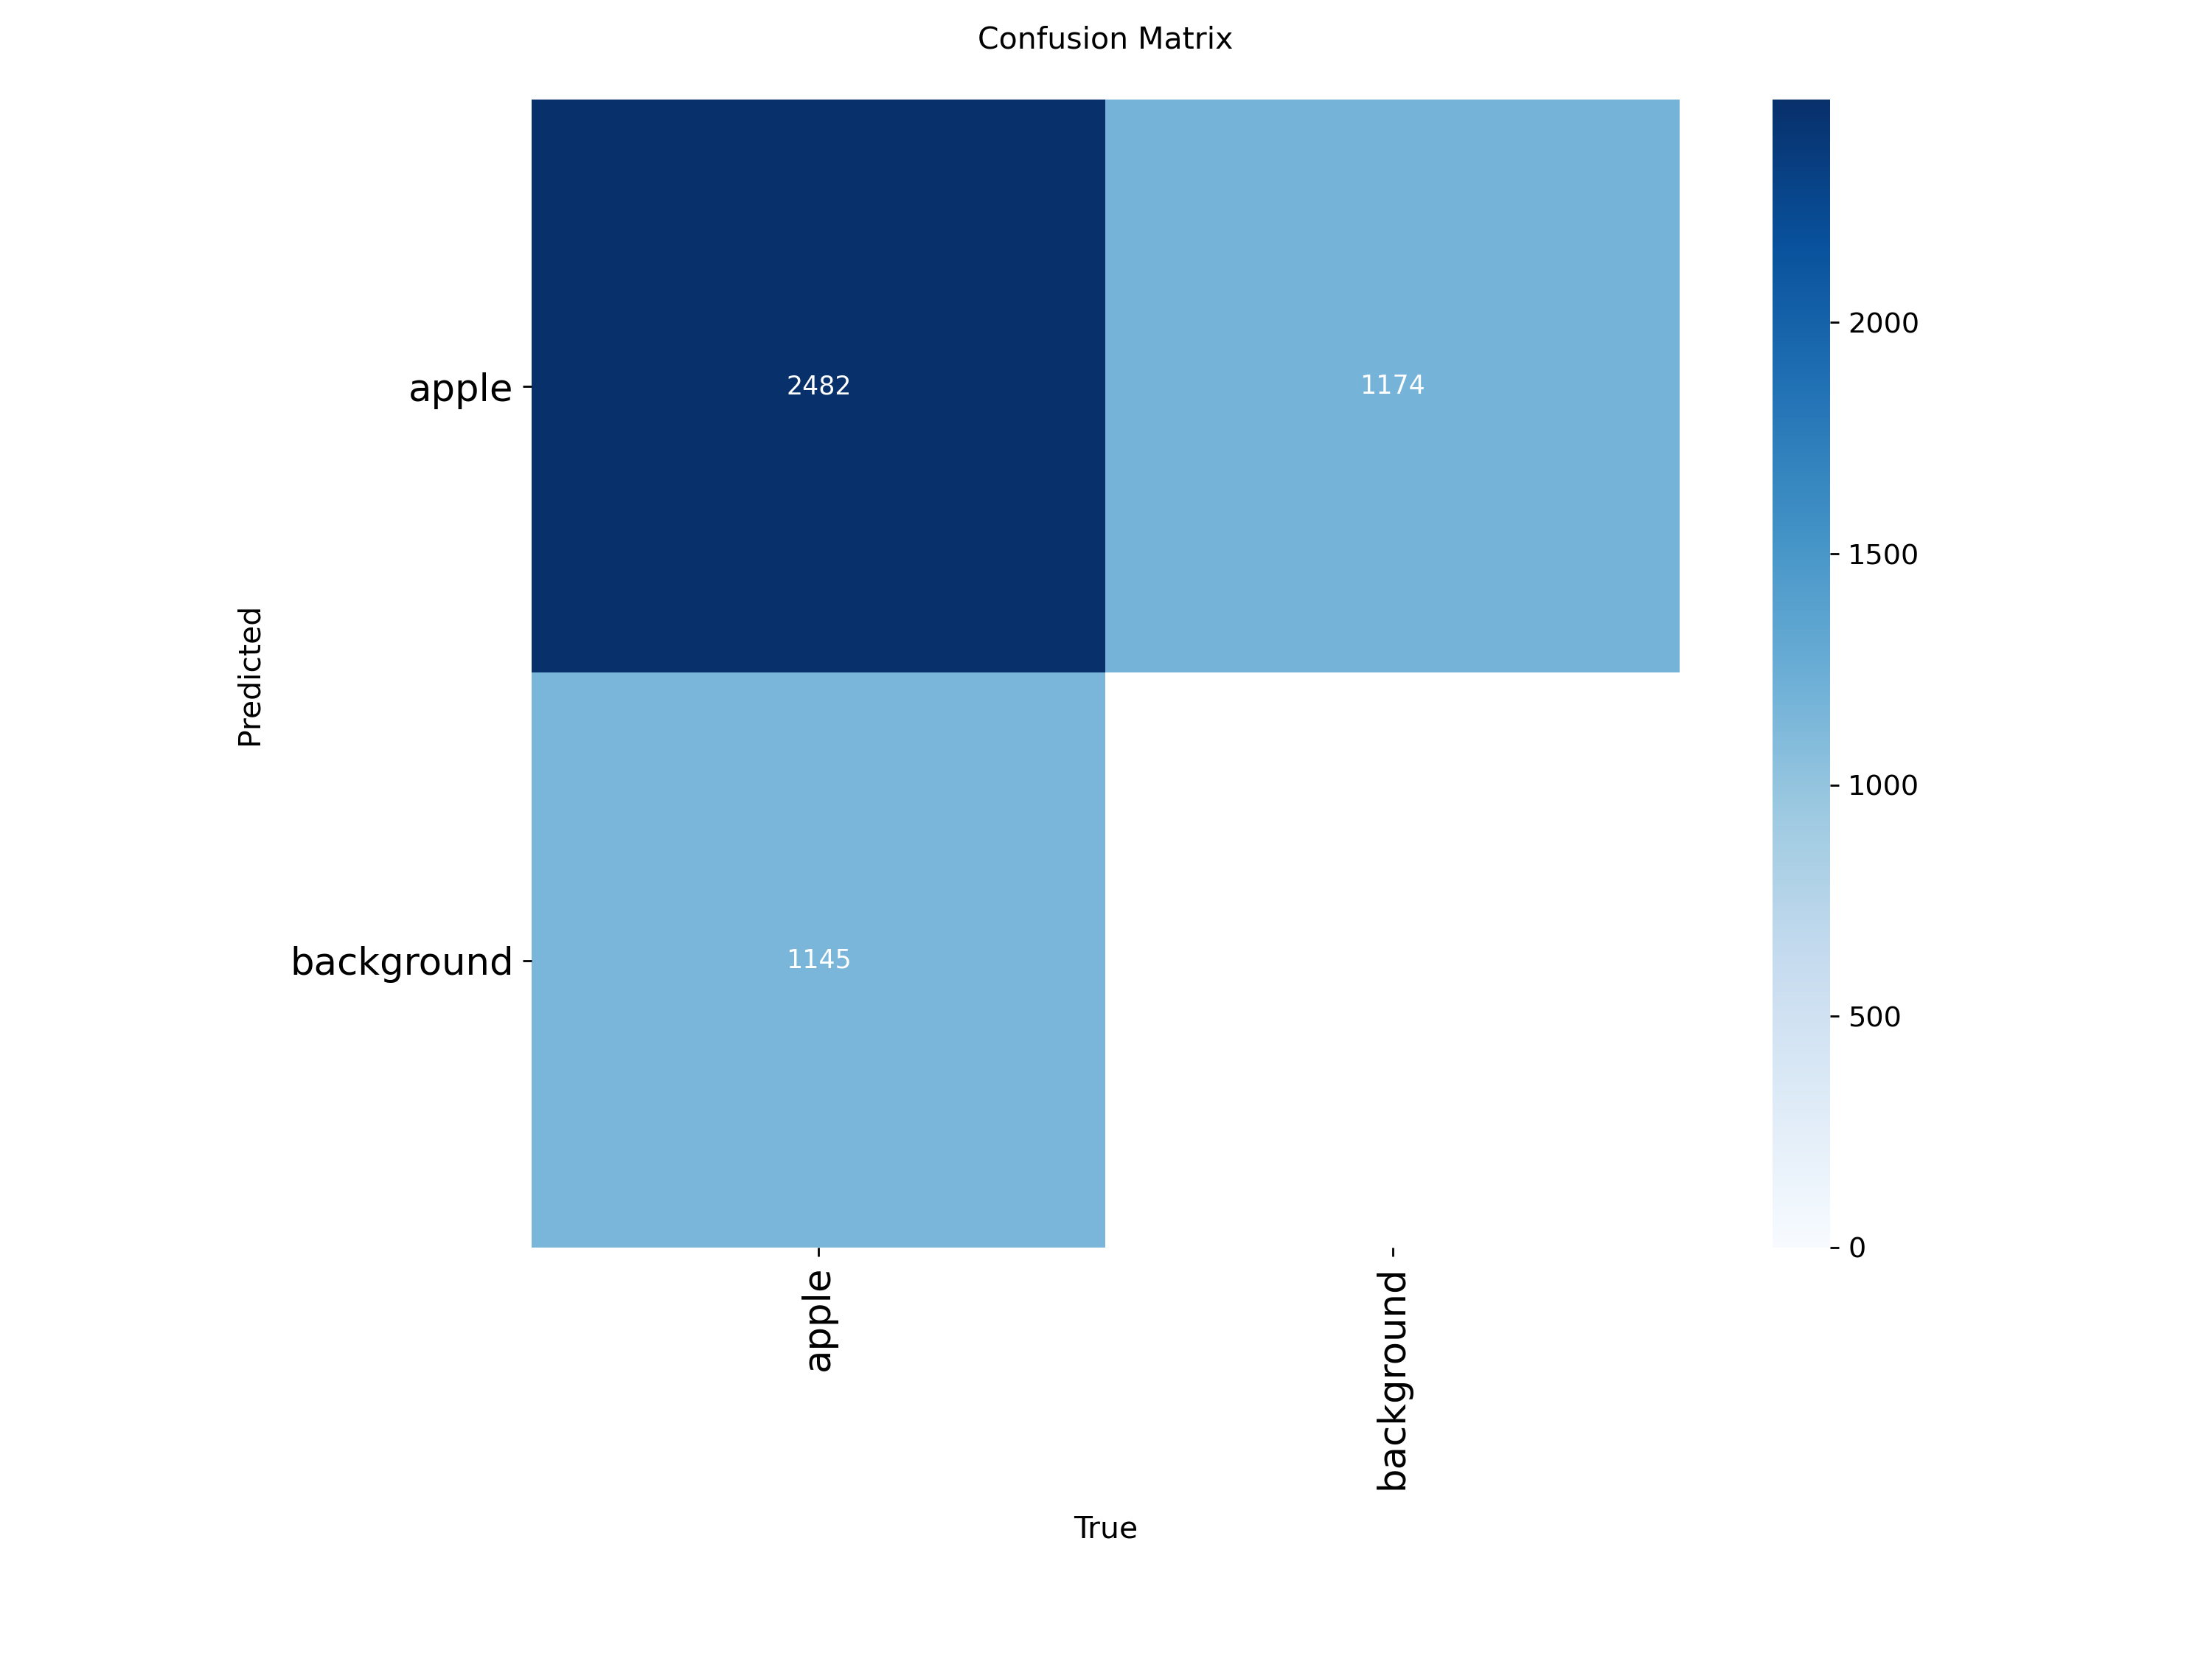


Visualizing predictions on sample images...


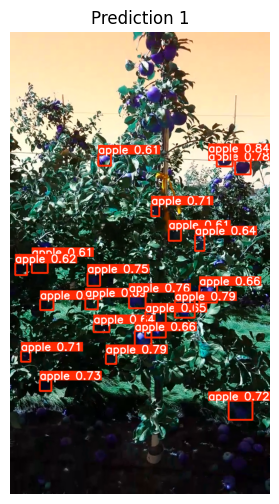

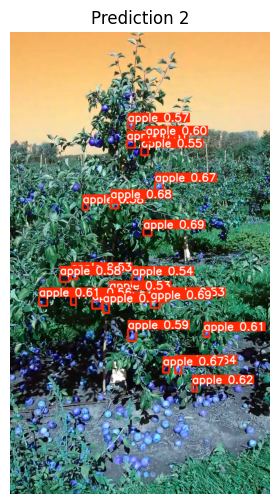

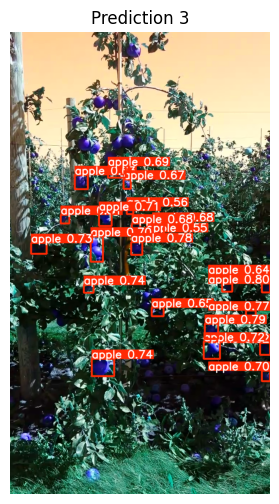


Saving model...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/experiment8/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (31.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.56...
ONNX: export success ✅ 7.4s, saved as 'runs/detect/experiment8/weights/best.onnx' (58.7 MB)

Export complete (9.7s)
Results saved to /content/runs/detect/experiment8/weights
Predict:         yolo predict task=detect model=runs/detect/experiment8/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/experiment8/weights/best.onnx imgsz=640 data=/content/drive/MyDrive/minneApple_dataset/minneapple.yaml  
Visualize:       https://netron.app
Model exported in ONNX format

Training and evaluation completed!
Model saved in: runs/detect/experiment
Predictions visualization saved as 'predictions.png'


In [ ]:

if __name__ == "__main__":
    # Configuration
    EPOCHS = 100
    print(os.getcwd())

    # Set-up dataset location
    dataset_path = Path("/content/drive/MyDrive/minneApple_dataset")
    val_images_path = os.path.join(dataset_path, "valid/images")


    # Verify dataset structure
    print("\nDataset structure:")
    print(f"Images directory: {dataset_path / 'train' / 'images'}")
    num_images = len(list((dataset_path / 'train' / 'images').glob('*.png')))
    print(f"Number of images: {num_images}")
    if num_images == 0:
        raise RuntimeError("No images found in dataset")

    # Experiment name
    train_name = "experiment"

    # Train model
    print("\nStarting training process...")
    model, results = train_yolo_model(dataset_path, epochs=EPOCHS, train_name=train_name)

    model.predict(
        source=str(dataset_path / "test/images"),
        save_txt=True,
        save_conf=True,
        conf=0.1,
        project="/content/drive/MyDrive/yolo10_output",
        name="predict_test",
        exist_ok=True
    )


    # Evaluate model
    metrics = evaluate_model(model, dataset_path)
    evaluate_model_on_counting()
    show_confusion_matrix(metrics)

    # Visualize predictions
    print("\nVisualizing predictions on sample images...")
    visualize_predictions(model, dataset_path / 'minneapple.yaml', conf_threshold=0.5)

    # Save the model
    print("\nSaving model...")
    model.export(format='onnx')
    print("Model exported in ONNX format")


    print("\nTraining and evaluation completed!")
    print(f"Model saved in: runs/detect/{train_name}")
    print("Predictions visualization saved as 'predictions.png'")


    # Delete specific variables
    del model, results, metrics  # Add any other large variables
    gc.collect()
